### HMDA (Home Mortgage Disclosure Act) Dataset

This dataset is about mortage (*Hypothek*) applications.  
We want to find out which factors influence the denial of the applications and if there might be a racial discrimination.  
For this, we train supervised machine learning algorithms on the provided dataset and try to interpret the trained models.

| Variable | Description |
|---|---|
| dir | debt payments to total income ratio  |
| hir  | housing expenses to income ratio  |
| lvr  | ratio of size of loan to assessed value of property  |
| ccs | consumer credit score from 1 to 6 (a low value being a good score) |
| mcs | mortgage credit score from 1 to 4 (a low value being a good score) |
| pbcr | public bad credit record? |
| dmi | denied mortgage insurance? |
| self | self employed? |
| single | is the applicant single? |
| uria | 1989 Massachusetts unemployment rate in the applicant’s industry |
| condominium | is unit a condominium (*Eigentumswohnung*)? |
| black | is the applicant black? |
| deny | mortgage application denied? |

In [0]:
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, classification_report
from sklearn import preprocessing

### Loading and Preprocessing

Next cell is for Uploading "Hdma.csv":

In [3]:
from google.colab import files
files.upload()

Saving Hdma.csv to Hdma.csv


{'Hdma.csv': b'"dir";"hir";"lvr";"ccs";"mcs";"pbcr";"dmi";"self";"single";"uria";"condo";"black";"deny"\r\n0.221000003814697;0.221000003814697;0.8;5;2;"no";"no";"no";"no";3.90000009536743;0;"no";"no"\r\n0.265;0.265;0.921875;2;2;"no";"no";"no";"yes";3.20000004768372;0;"no";"no"\r\n0.372000007629395;0.247999992370605;0.920398009950249;1;2;"no";"no";"no";"no";3.20000004768372;0;"no";"no"\r\n0.32;0.25;0.86046511627907;1;2;"no";"no";"no";"no";4.30000019073486;0;"no";"no"\r\n0.36;0.35;0.6;1;1;"no";"no";"no";"no";3.20000004768372;0;"no";"no"\r\n0.24;0.17;0.510526315789474;1;1;"no";"no";"no";"no";3.90000009536743;0;"no";"no"\r\n0.35;0.29;0.746666666666667;1;2;"no";"no";"no";"yes";3.90000009536743;1;"no";"no"\r\n0.28;0.22;0.85;2;2;"no";"no";"no";"no";1.79999995231628;0;"no";"no"\r\n0.31;0.24;0.897260273972603;2;2;"no";"yes";"no";"no";3.09999990463257;0;"no";"yes"\r\n0.18;0.17;0.358744394618834;2;1;"no";"no";"no";"yes";3.90000009536743;0;"no";"no"\r\n0.28;0.27;0.223880597014925;1;2;"no";"no";"no

The dataset contains only one row with missing data fields, therefore we decided to just drop this one data row.  
We also translate the strings "yes" and "no" from the input to binary values 0 and 1.

In [74]:
data = pd.read_csv("Hdma.csv", sep=";")
data.dropna(inplace=True)   # Only 1 row affected, so just drop it.
data.replace(('yes', 'no'), (1, 0), inplace=True)

data

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,0,0,0,0,3.9,0,0,0
1,0.265,0.265,0.921875,2.0,2.0,0,0,0,1,3.2,0,0,0
2,0.372,0.248,0.920398,1.0,2.0,0,0,0,0,3.2,0,0,0
3,0.320,0.250,0.860465,1.0,2.0,0,0,0,0,4.3,0,0,0
4,0.360,0.350,0.600000,1.0,1.0,0,0,0,0,3.2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,0.310,0.250,0.800000,1.0,1.0,0,0,1,0,3.2,0,0,0
2376,0.300,0.300,0.777049,1.0,2.0,0,0,0,1,3.2,1,0,0
2377,0.260,0.200,0.526761,2.0,1.0,0,0,0,0,3.1,0,0,0
2378,0.320,0.260,0.753846,6.0,1.0,1,0,0,1,3.1,1,1,1


In [75]:
data.describe()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
count,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000,2380.000000
mean,0.330814,0.255346,0.737776,2.116387,1.721008,0.073529,0.020168,0.116387,0.393277,3.774496,0.288235,0.142437,0.119748
std,0.107257,0.096656,0.178751,1.666721,0.537282,0.261058,0.140604,0.320755,0.488580,2.027062,0.453036,0.349571,0.324735
min,0.000000,0.000000,0.020000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000
25%,0.280000,0.214000,0.652681,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.100000,0.000000,0.000000,0.000000
50%,0.330000,0.260000,0.779536,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.200000,0.000000,0.000000,0.000000
75%,0.370000,0.298825,0.868459,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.900000,1.000000,0.000000,0.000000
max,3.000000,3.000000,1.950000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,10.600000,1.000000,1.000000,1.000000


In [76]:
data['deny'].value_counts()

0    2095
1     285
Name: deny, dtype: int64

We can see that the class labels are very inbalanced.  
For some ML algorithms, highly inbalanced labels can lead to problems like bias (prefering to just predict one class).  
By using class_weight = 'balanced' on those methods, we can give errors on the rare classes more weight and therefore achieve better recall rates.

### Preparation for ML algorithm

Next, we separate the target column as Y values from the feature columns, rescale to the Interval [0,1] and do a train/test split.

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()

X = min_max_scaler.fit_transform(data.drop('deny', axis=1).to_numpy())
y = data['deny'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Logistic Regression

Next, we will use statsmodels for a logistic regression, as the sklearn logistic regression doesn't support significance values.

In [78]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

X_train_with_intercept = add_constant(X_train)
smodel = sm.Logit(y_train, X_train_with_intercept)
lr = smodel.fit()
print(lr.summary(xname=['intercept'] + list(data.columns)[:-1]))

Optimization terminated successfully.
         Current function value: 0.262954
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1904
Model:                          Logit   Df Residuals:                     1891
Method:                           MLE   Df Model:                           12
Date:                Sun, 10 May 2020   Pseudo R-squ.:                  0.2761
Time:                        14:18:58   Log-Likelihood:                -500.66
converged:                       True   LL-Null:                       -691.66
Covariance Type:            nonrobust   LLR p-value:                 2.447e-74
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.4450      0.548    -11.752      0.000      -7.520      -5.370
dir           13.6568      3.

Looking at the regression model, all the coefficients are nonzero. We now want to test which of the coefficients are actual significant (different from zero).

For this, we assume the Null-Hypothesis "the coefficient actually is 0" and look at the column P>|z|. It shows how likely it is to get this z-value given the Null-Hypothesis holds. We take a standard significant niveau of 0.05 and reject the Null-Hypothesis if the probability is <= 0.05. In that case, the coefficient is significantly different from 0.

Looking at the table, we see that all coefficients except hir and condo are significant.  
The most important factor for a mortgage denial according to this model is the dir. This is reasonable, as the hight of debt paysments in relation to income should play a very important role at assessing a mortgage application.  
The probability that the coefficient for the value "black" is significant is almost certain, although the value of the coefficient is not very high. This might indicate a small (racial discrimination) impact of the applicant beeing black influencing the denial of the mortgage.

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       416
           1       0.84      0.27      0.41        60

    accuracy                           0.90       476
   macro avg       0.87      0.63      0.68       476
weighted avg       0.90      0.90      0.88       476



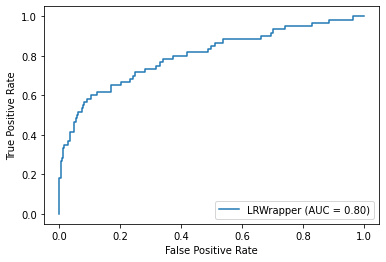

In [114]:
# Minimal skikit-model wrapper to enable plotting ROC for statsmodels regression model
class LRWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, border=0.5):
        self.model = model
        self.classes_ = [0, 1]
        self.border_ = border
    def predict_proba(self, X):
        return self.model.predict(add_constant(X))
    def predict(self, X):
        return self.model.predict(add_constant(X)) > self.border_

plot_roc_curve(LRWrapper(lr), X_test, y_test)

y_pred = LRWrapper(lr).predict(X_test)
print(classification_report(y_test, y_pred))

The AUC of this model is already reasonable good.  
Unfortenatley, the recall (of the positive class) with the standard decision boundary at 0.5 is relatively low.  
We try if we can get better results using more complex ML-Methods next. 

### Baseline: Most frequent class

First, we just predict the most frequent class for each sample. As seen above, the most frequent class is 0 (to not deny the mortgage).

In [80]:
y_pred = [0] * len(y_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       416
           1       0.00      0.00      0.00        60

    accuracy                           0.87       476
   macro avg       0.44      0.50      0.47       476
weighted avg       0.76      0.87      0.82       476



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected for such an unbalanced dataset, the (non-weighted) accuracy is relatively high (87%). However, this model of course is not usefull at all, as it always predicts to not deny any mortgage application and therefore has a recall (on the positive class) of 0.

This "model" has no ROC (and no AUC), as it always has the same output and there is no boundary value to optimize. 

### Decision Tree

In [81]:
dt = DecisionTreeClassifier(criterion='entropy', class_weight="balanced")
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [82]:
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       416
           1       0.38      0.30      0.33        60

    accuracy                           0.85       476
   macro avg       0.64      0.61      0.62       476
weighted avg       0.84      0.85      0.84       476



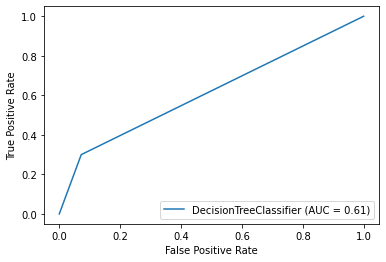

In [83]:
plot_roc_curve(dt, X_test, y_test)

We now look at the feature importance values.  
They are not directly comparable to the coefficients of the logistic regression model, as they are computed completely different and are not even on the same scale.
The coefficients are the parameters of a mathematical model, while the feature importances are computed by the estimated information gain from one feature throughout an ML-Model and sum up to one.

In [84]:
for col, coef in zip(data.columns, dt.feature_importances_):
  print(col + " : " + str(coef))

dir : 0.20241200985490576
hir : 0.11182779449523908
lvr : 0.2835840807950874
ccs : 0.1187382613707988
mcs : 0.02582821649834299
pbcr : 0.0263338945529855
dmi : 0.0753819665266515
self : 0.00961802117792921
single : 0.025300195003275665
uria : 0.07288753187680408
condo : 0.02507052013322412
black : 0.02301750771475564


The model performance of a single decision tree is not very good. Therefore, we try a random forest next.

### Random Forest

In [87]:
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       416
           1       0.79      0.25      0.38        60

    accuracy                           0.90       476
   macro avg       0.85      0.62      0.66       476
weighted avg       0.89      0.90      0.87       476



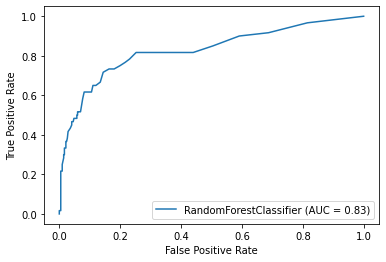

In [89]:
plot_roc_curve(rf, X_test, y_test)

The performance of the random forest according to the AUC of the ROC is the best of all models we try out.  
Taking a look at the feature importance, dir again plays an important role, as well as hir and lvr.
The importance of the black feature is relatively low.

In [90]:
for col, coef in zip(data.columns, rf.feature_importances_):
  print(col + " : " + str(coef))

dir : 0.19745364833205503
hir : 0.1521605251245587
lvr : 0.19299005832564695
ccs : 0.11783910576887971
mcs : 0.03252911023915042
pbcr : 0.05314037947840454
dmi : 0.06186663953946581
self : 0.020244169192875486
single : 0.027594685697701085
uria : 0.08481766228118864
condo : 0.022463292325830053
black : 0.03690072369424381


### AdaBoost

In [91]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [92]:
y_pred = ab.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       416
           1       0.79      0.32      0.45        60

    accuracy                           0.90       476
   macro avg       0.85      0.65      0.70       476
weighted avg       0.89      0.90      0.88       476



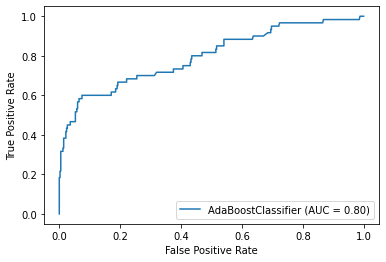

In [93]:
plot_roc_curve(ab, X_test, y_test)

In [94]:
for col, coef in zip(data.columns, ab.feature_importances_):
  print(col + " : " + str(coef))

dir : 0.22
hir : 0.18
lvr : 0.34
ccs : 0.12
mcs : 0.02
pbcr : 0.02
dmi : 0.02
self : 0.02
single : 0.02
uria : 0.02
condo : 0.0
black : 0.02


The performance of the model according to the AUC of the ROC is good.
Taking a look at the feature importance, dir again plays an important role, as well as hir and lvr. The importance of the black feature is relatively low.

### Naive Bayes

In [95]:
nb = ComplementNB()
nb.fit(X_train, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [96]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       416
           1       0.32      0.48      0.39        60

    accuracy                           0.81       476
   macro avg       0.62      0.67      0.64       476
weighted avg       0.84      0.81      0.82       476



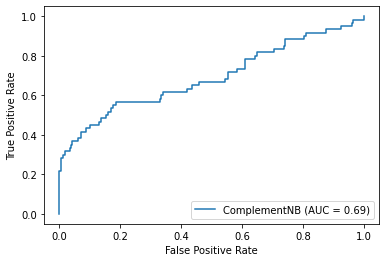

In [97]:
plot_roc_curve(nb, X_test, y_test)

In [98]:
print("Class 1 Prior: " + str(nb.class_log_prior_[1]))
for col, coef in zip(data.columns, nb.feature_log_prob_[1]):
  print(col + " : " + str(coef))

Class 1 Prior: -2.13561181314689
dir : 2.988573337821578
hir : 3.241262781034901
lvr : 1.7669182230556504
ccs : 2.410533994315014
mcs : 2.2149266008094077
pbcr : 3.7604607112640296
dmi : 6.581839597673243
self : 2.9763417524983575
single : 1.7329392267625532
uria : 2.2894517543861514
condo : 2.025859655875923
black : 2.8979726853828507


The naive bayes approach has a poor performance according to AUC of ROC. This is highly likely the case because of the naive indipendence assumption, which defenitly does not hold true in our dataset.
The log probabilities of the features cannot be compared directly to the feature importances or coefficients of the regression, but we see that Naive Bayes gives much probability to dmi, which is also important for the regression model, but not for the other models.  
The Naive Bayes also shows some amount of probability for the black feature.

### SVM

In [99]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [100]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       416
           1       0.36      0.62      0.45        60

    accuracy                           0.81       476
   macro avg       0.65      0.73      0.67       476
weighted avg       0.86      0.81      0.83       476



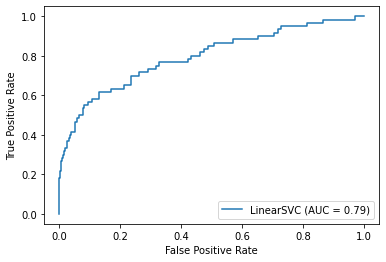

In [101]:
plot_roc_curve(svm, X_test, y_test)

In [102]:
print("intercept: " + str(svm.intercept_[0]))
for col, coef in zip(data.columns, svm.coef_[0]):
  print(col + " : " + str(coef))

intercept: -1.5369053218912863
dir : 3.64490033038227
hir : -0.12370534507456783
lvr : 1.0588417490113744
ccs : 0.6640805025593969
mcs : 0.29789187307791654
pbcr : 0.41381371093766073
dmi : 1.2891305007099847
self : 0.2910902994364597
single : 0.1733288581213661
uria : 0.3599241192521282
condo : -0.0024210061010699682
black : 0.3352649885301663


The performance of the model according to the AUC of the ROC is good.
The coefficients show use of the dir and lvr features, like most other models and also the dmi.
The medium coefficient for the black feature indicates a small influence on the denial decision. 

## Conclusion
After training and analysing different ML-Models, their interpretation gives indications of a slight racial bias towards denying applications for black people.  
While we were able to find some signs of racial discrimination in most of the learned ML-Models, further analysis needs to be done.  

Most learned models achieved a good AUC of the ROC, but only a modest performance (Assessed by the F1-Score of the positive class) when using the default threshold of 0.5. Even though the AdaBoost Model has an Accuracy of 90%, it still only finds about 1/3 of all denials in the test dataset when using that threshold.
Therefore, we recommend to try to otpimize the hyperparameters of the ML-Models to achieve better results.